**Mount Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import Libraries**

In [2]:
!pip install fastai --upgrade -q

In [3]:
from fastai.vision.all import *

from fastai.metrics import accuracy_multi
from torchvision.models import resnet34

import PIL

In [4]:
path = Path('drive/My Drive/Dataset/RFMID/data')

In [5]:
!ls 'drive/My Drive/Dataset/RFMID/data/Training_Set/Training/' -1 | wc -l

1920


### Get Data

In [6]:
df = pd.read_csv(path/'Training_Set/RFMiD_Training_Labels.csv')

In [7]:
df

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,MS,CSR,ODC,CRVO,TV,AH,ODP,ODE,ST,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,1916,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1916,1917,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1917,1918,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1918,1919,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Disease Screening Data

In [8]:
batch_tfms = aug_transforms(size=256, min_scale=0.75)

In [9]:
# Disease Screening
s_block = DataBlock(blocks=(ImageBlock(),CategoryBlock()),
                    splitter=RandomSplitter(),
                    get_x=ColReader(0, pref=f'{path}/Training_Set/Training/', suff='.png'),
                    get_y=ColReader(1),
                    item_tfms=Resize(1024),
                    batch_tfms=batch_tfms)

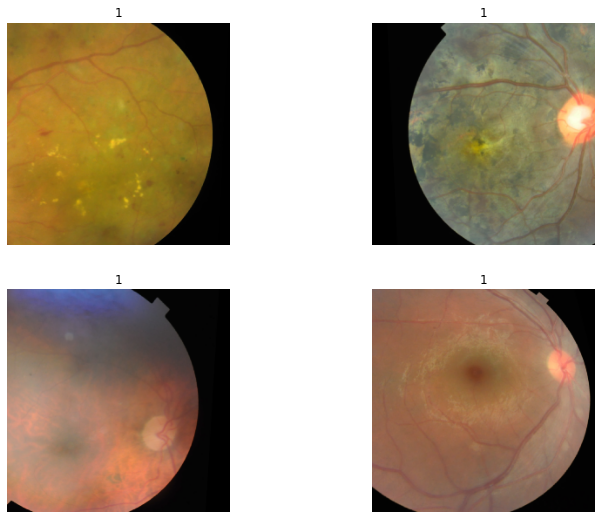

In [10]:
s_dls = s_block.dataloaders(df[:128],bs=16)
s_dls.show_batch(max_n=4, figsize=(12,9))

### Disease Classification Data

In [ ]:
batch_tfms = aug_transforms(size=512, min_scale=0.75)

In [ ]:
classes = list(df.columns[2:])

In [ ]:
def get_y(r): return r[classes].values.astype(np.int32)

In [ ]:
# Multi-Label
d_block = DataBlock(blocks=(ImageBlock(),MultiCategoryBlock(encoded=True,vocab=classes)),
                    splitter=RandomSplitter(),
                    get_x=ColReader(0,pref=f'{path}/Training_Set/Training/', suff='.png'),
                    get_y=get_y,
                    item_tfms=Resize(1024),
                    batch_tfms=batch_tfms)

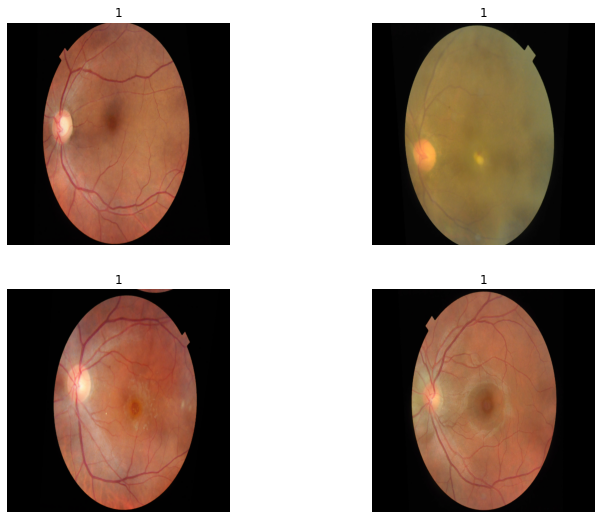

In [ ]:
d_dls = d_block.dataloaders(df,bs=64)
d_dls.show_batch()

## Train Model

### Disease Screening

In [11]:
model = xresnet50(n_out=s_dls.c)

In [12]:
screener = Learner(s_dls, model, metrics=[accuracy, RocAucBinary()], loss_func=CrossEntropyLossFlat())

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.00015848931798245758)

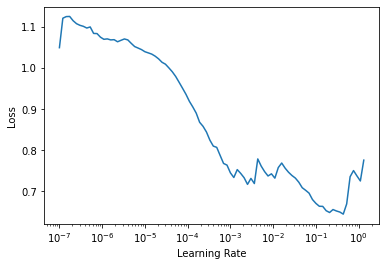

In [13]:
screener.lr_find()

In [15]:
screener.fit_one_cycle(10, 3e-04)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.971466,0.710403,0.600000,0.511905,00:13
1,0.760576,0.468448,0.840000,0.607143,00:12
2,0.619973,0.515430,0.840000,0.571429,00:12
3,0.554960,0.628872,0.840000,0.559524,00:12
4,0.498551,0.617215,0.840000,0.607143,00:12
5,0.459414,0.606207,0.840000,0.547619,00:12
6,0.441952,0.585104,0.800000,0.595238,00:12
7,0.419533,0.571326,0.840000,0.595238,00:12
8,0.396713,0.545670,0.840000,0.595238,00:12
9,0.375373,0.559586,0.840000,0.607143,00:12


### Multi-Label

In [ ]:
class BCEWithLogitsLossFlat(BaseLoss):
    "Same as `nn.CrossEntropyLoss`, but flattens input and target."
    def __init__(self, *args, axis=-1, floatify=True, thresh=0.5, **kwargs):
        super().__init__(nn.BCEWithLogitsLoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
        self.thresh = thresh

    def decodes(self, x):    return x>self.thresh
    def activation(self, x): return torch.sigmoid(x)

In [ ]:
model = xresnet50(n_out=d_dls.c)

In [ ]:
classifier = Learner(d_dls, model, metrics=[accuracy_multi, A], loss_func=BCEWithLogitsLossFlat())

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.14454397559165955)

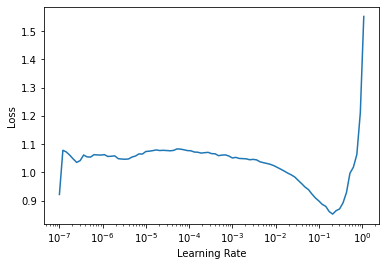

In [ ]:
classifier.lr_find()

In [ ]:
lr = 5e-2
learn = learn.to_fp16()

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_multi,time
0,1.101087,8.582694,0.148810,00:04
1,0.889292,1.340969,0.613095,00:04
2,0.679198,0.450824,0.934524,00:04
3,0.573460,0.530299,0.946429,00:04
4,0.510926,0.534044,0.946429,00:04
